# 数据预处理

In [1]:
import h5py
import numpy as np
import tensorflow as tf 
import keras
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization,concatenate, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

file = h5py.File('DB3//DB3_S1_image.h5','r')
imageData   = file['imageData'][:]
imageData   = imageData*2000
imageLabel  = file['imageLabel'][:]  
file.close()

# 随机打乱数据和标签
N = imageData.shape[0]
index = np.random.permutation(N)
data  = imageData[index,:,:]
label = imageLabel[index]

# 对数据升维,标签one-hot
data  = np.expand_dims(data, axis=3)
label = convert_to_one_hot(label,16).T

# 划分数据集
N = data.shape[0]
num_train = round(N*0.8)
X_train = data[0:num_train,:,:,:]
Y_train = label[0:num_train,:]
X_test  = data[num_train:N,:,:,:]
Y_test  = label[num_train:N,:]

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

/home/malele/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


X_train shape: (3827, 200, 6, 1)
Y_train shape: (3827, 16)
X_test shape: (957, 200, 6, 1)
Y_test shape: (957, 16)


In [2]:
#写一个LossHistory类，保存loss和acc
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()


# 建立模型

In [3]:
def CNN(input_shape=(200,6,1), classes=16): 
    X_input = Input(input_shape)
    
    X = Conv2D(filters=32, kernel_size=(20,3), strides=(1,1), activation='relu', padding='same')(X_input)
    X = MaxPooling2D((20,1))(X)

    X = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')(X)
    X = MaxPooling2D((2,1))(X)
    
    X = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu',padding='valid')(X)
    
    X = Flatten(name='flatten')(X)
    X = Dropout(0.5)(X)
    X = Dense(128,activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation='softmax')(X)
    model = Model(inputs=X_input, outputs=X)
    return model
    
model = CNN()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 6, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 6, 32)        1952      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 6, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 6, 64)         18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 4, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
__________

# 训练原始数据

In [4]:
import time
start = time.time()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = LossHistory() # 创建一个history实例
model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test),batch_size=64,callbacks=[history])

preds_train = model.evaluate(X_train, Y_train)
print("Train Loss = " + str(preds_train[0]))
print("Train Accuracy = " + str(preds_train[1]))

preds_test  = model.evaluate(X_test, Y_test)
print("Test Loss = " + str(preds_test[0]))
print("Test Accuracy = " + str(preds_test[1]))

end = time.time()
print("time:",end-start)

Train on 3827 samples, validate on 957 samples
Epoch 1/100
3827/3827 [==============================] - 4s 920us/step - loss: 2.3634 - acc: 0.1897 - val_loss: 1.5449 - val_acc: 0.4389
Epoch 2/100
3827/3827 [==============================] - 3s 813us/step - loss: 1.4834 - acc: 0.4769 - val_loss: 1.0238 - val_acc: 0.6855
Epoch 3/100
3827/3827 [==============================] - 3s 775us/step - loss: 1.1063 - acc: 0.5986 - val_loss: 0.7561 - val_acc: 0.7419
Epoch 4/100
3827/3827 [==============================] - 3s 792us/step - loss: 0.8938 - acc: 0.6807 - val_loss: 0.6090 - val_acc: 0.7806
Epoch 5/100
3827/3827 [==============================] - 4s 1ms/step - loss: 0.7320 - acc: 0.7327 - val_loss: 0.5014 - val_acc: 0.8245
Epoch 6/100
3827/3827 [==============================] - 4s 1ms/step - loss: 0.6317 - acc: 0.7682 - val_loss: 0.4471 - val_acc: 0.8422
Epoch 7/100
3827/3827 [==============================] - 4s 1ms/step - loss: 0.5528 - acc: 0.8011 - val_loss: 0.4170 - val_acc: 0.8359


Epoch 61/100
3827/3827 [==============================] - 4s 1ms/step - loss: 0.1109 - acc: 0.9545 - val_loss: 0.2916 - val_acc: 0.9185
Epoch 62/100
3827/3827 [==============================] - 4s 1ms/step - loss: 0.1197 - acc: 0.9548 - val_loss: 0.2661 - val_acc: 0.9237
Epoch 63/100
3827/3827 [==============================] - 4s 1ms/step - loss: 0.1185 - acc: 0.9540 - val_loss: 0.2827 - val_acc: 0.9195
Epoch 64/100
3827/3827 [==============================] - 4s 1ms/step - loss: 0.1091 - acc: 0.9587 - val_loss: 0.2561 - val_acc: 0.9227
Epoch 65/100
3827/3827 [==============================] - 4s 1ms/step - loss: 0.1112 - acc: 0.9566 - val_loss: 0.2531 - val_acc: 0.9227
Epoch 66/100
3827/3827 [==============================] - 4s 1ms/step - loss: 0.1145 - acc: 0.9543 - val_loss: 0.2987 - val_acc: 0.9122
Epoch 67/100
3827/3827 [==============================] - 4s 1ms/step - loss: 0.1182 - acc: 0.9561 - val_loss: 0.3216 - val_acc: 0.8997
Epoch 68/100
3827/3827 [========================

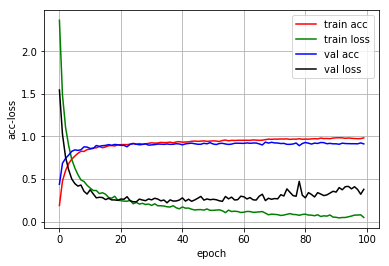

In [5]:
history.loss_plot('epoch')